In [2]:
import os

import numpy as np
import pandas as pd
import csv

import random

# import the dataset splitting functionalities ...
from sklearn.model_selection import train_test_split
# ... and the scalers (for normalizations)

from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Activation
from keras import backend as K
keras.backend.set_floatx('float64')
from keras.callbacks import EarlyStopping

import scipy

import matplotlib.pyplot as plt

In [3]:
def scale_params(params, lb, ub):
    l = len(params)
    res = np.zeros(l)
    for i in range(l):
        res[i] = (2*params[i] - (ub[i] + lb[i])) / (ub[i] - lb[i])        
    return res

def back_params(params, lb, ub):
    l = len(params)
    res = np.zeros(l)
    for i in range(l):
        res[i] = 0.5*(ub[i]-lb[i])*params[i] + 0.5*(ub[i]+lb[i])
    return res


In [4]:
import meta_fxdGrid as meta

spot = 1.0

maturities = np.array(meta.tGrid)
print('maturities: ' + str(maturities))
N_maturities = len(maturities)

strikes = np.array(meta.kGrid)
print('strikes: ')
print(str(strikes))
N_strikes = len(strikes)

#     kappa  theta  sigma   v0   rho   
lb = [ 2.00,   .01,  1.00, .01, -.90]
ub = [ 6.00,   .20,  2.50, .20, -.50]

N_ivols = N_maturities*N_strikes
    
N_params = len(lb)

maturities: [0.1 0.3 0.6 0.9 1.2 1.5 1.8 2. ]
strikes: 
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]


In [5]:
def histo_array(keys, x):
    LEN = len(keys)
    fig, ax = plt.subplots(1, LEN, figsize=(14,4))
    for n in range(LEN):
        k    = keys[n]
        lo   = np.min(x[:,n])
        hi   = np.max(x[:,n])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[:,n], density=True, facecolor='g', bins=bins)
        ax[n].set_title(k)
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()

#### Explain the file!!!!

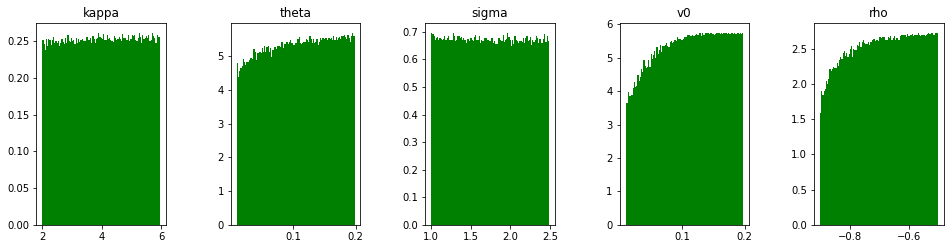

In [7]:
data = np.loadtxt('Heston_samples_fxdGrid_train.txt', dtype=float)
histo_array(["kappa", "theta", "sigma", "v0", "rho"], data[:,0:N_params])
    
params = data[:, :N_params]
i_vols = data[:, N_params:]

### Normalize implied volatility

In [9]:
x_train = params
y_train = i_vols

In [10]:
scale_impVol = StandardScaler()
y_train_transform = scale_impVol.fit_transform(y_train)

### Normalize model parameters using special scaler from Refs

In [11]:
x_train_transform = np.array([scale_params(x, lb, ub) for x in x_train])

In [12]:
N_hiddenLayers = 4
N_nodes = 30
i = keras.layers.Input(shape=(N_params, ))
x = keras.layers.Dense(N_nodes, activation='elu')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='elu')(x)
    c += 1
x = keras.layers.Dense(N_ivols, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 30)                180       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 88)                2728  

In [13]:
N_epochs = 500
patience = 50
earlystop = EarlyStopping(monitor="loss",
                          min_delta=0,
                          mode="min",
                          verbose=1,
                          patience=patience)

def RMSE(y, y_hat):
    return K.sqrt(K.mean(K.square(y_hat - y)))

model.compile(loss = RMSE, optimizer = "adam")

model.fit(x_train_transform, y_train_transform, batch_size=32, epochs=N_epochs, verbose=True, shuffle=1, callbacks=[earlystop])

Epoch 1/500
952/952 [==============================] - 1s 898us/step - loss: 0.1558
Epoch 2/500
952/952 [==============================] - 1s 839us/step - loss: 0.0501
Epoch 3/500
952/952 [==============================] - 1s 874us/step - loss: 0.0386
Epoch 4/500
952/952 [==============================] - 1s 839us/step - loss: 0.0336
Epoch 5/500
952/952 [==============================] - 1s 856us/step - loss: 0.0305
Epoch 6/500
952/952 [==============================] - 1s 841us/step - loss: 0.0281
Epoch 7/500
952/952 [==============================] - 1s 800us/step - loss: 0.0267
Epoch 8/500
952/952 [==============================] - 1s 844us/step - loss: 0.0246
Epoch 9/500
952/952 [==============================] - 1s 829us/step - loss: 0.0235
Epoch 10/500
952/952 [==============================] - 1s 866us/step - loss: 0.0223
Epoch 11/500
952/952 [==============================] - 1s 894us/step - loss: 0.0216
Epoch 12/500
952/952 [==============================] - 1s 865us/step - lo

952/952 [==============================] - 1s 824us/step - loss: 0.0134
Epoch 98/500
952/952 [==============================] - 1s 858us/step - loss: 0.0134
Epoch 99/500
952/952 [==============================] - 1s 877us/step - loss: 0.0132
Epoch 100/500
952/952 [==============================] - 1s 863us/step - loss: 0.0136
Epoch 101/500
952/952 [==============================] - 1s 853us/step - loss: 0.0136
Epoch 102/500
952/952 [==============================] - 1s 822us/step - loss: 0.0131
Epoch 103/500
952/952 [==============================] - 1s 863us/step - loss: 0.0135
Epoch 104/500
952/952 [==============================] - 1s 866us/step - loss: 0.0133
Epoch 105/500
952/952 [==============================] - 1s 810us/step - loss: 0.0131
Epoch 106/500
952/952 [==============================] - 1s 856us/step - loss: 0.0130
Epoch 107/500
952/952 [==============================] - 1s 847us/step - loss: 0.0133
Epoch 108/500
952/952 [==============================] - 1s 857us/step

952/952 [==============================] - 1s 842us/step - loss: 0.0123
Epoch 193/500
952/952 [==============================] - 1s 838us/step - loss: 0.0123
Epoch 194/500
952/952 [==============================] - 1s 914us/step - loss: 0.0123
Epoch 195/500
952/952 [==============================] - 1s 854us/step - loss: 0.0124
Epoch 196/500
952/952 [==============================] - 1s 809us/step - loss: 0.0123
Epoch 197/500
952/952 [==============================] - 1s 857us/step - loss: 0.0121
Epoch 198/500
952/952 [==============================] - 1s 829us/step - loss: 0.0121
Epoch 199/500
952/952 [==============================] - 1s 826us/step - loss: 0.0124
Epoch 200/500
952/952 [==============================] - 1s 831us/step - loss: 0.0122
Epoch 201/500
952/952 [==============================] - 1s 838us/step - loss: 0.0123
Epoch 202/500
952/952 [==============================] - 1s 825us/step - loss: 0.0124
Epoch 203/500
952/952 [==============================] - 1s 875us/st

952/952 [==============================] - 1s 851us/step - loss: 0.0116
Epoch 288/500
952/952 [==============================] - 1s 872us/step - loss: 0.0118
Epoch 289/500
952/952 [==============================] - 1s 851us/step - loss: 0.0117
Epoch 290/500
952/952 [==============================] - 1s 836us/step - loss: 0.0118
Epoch 291/500
952/952 [==============================] - 1s 870us/step - loss: 0.0117
Epoch 292/500
952/952 [==============================] - 1s 808us/step - loss: 0.0115
Epoch 293/500
952/952 [==============================] - 1s 856us/step - loss: 0.0119
Epoch 294/500
952/952 [==============================] - 1s 828us/step - loss: 0.0118
Epoch 295/500
952/952 [==============================] - 1s 831us/step - loss: 0.0118
Epoch 296/500
952/952 [==============================] - 1s 836us/step - loss: 0.0116
Epoch 297/500
952/952 [==============================] - 1s 810us/step - loss: 0.0114
Epoch 298/500
952/952 [==============================] - 1s 843us/st

952/952 [==============================] - 1s 824us/step - loss: 0.0113
Epoch 383/500
952/952 [==============================] - 1s 826us/step - loss: 0.0111
Epoch 384/500
952/952 [==============================] - 1s 845us/step - loss: 0.0113
Epoch 385/500
952/952 [==============================] - 1s 833us/step - loss: 0.0113
Epoch 386/500
952/952 [==============================] - 1s 863us/step - loss: 0.0114
Epoch 387/500
952/952 [==============================] - 1s 900us/step - loss: 0.0112
Epoch 388/500
952/952 [==============================] - 1s 817us/step - loss: 0.0114
Epoch 389/500
952/952 [==============================] - 1s 841us/step - loss: 0.0109
Epoch 390/500
952/952 [==============================] - 1s 841us/step - loss: 0.0112
Epoch 391/500
952/952 [==============================] - 1s 839us/step - loss: 0.0113
Epoch 392/500
952/952 [==============================] - 1s 875us/step - loss: 0.0114
Epoch 393/500
952/952 [==============================] - 1s 856us/st

In [16]:
model.save_weights('Heston_NNWeights_fxdGrid.h5')

In [17]:
model.load_weights('Heston_NNWeights_fxdGrid.h5')

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

In [18]:
N_layers = N_hiddenLayers + 1

def elu(x):
    ind = (x<0)
    x[ind] = np.exp(x[ind])-1
    return x

def eluPrime(x):
    y = np.copy(x)
    ind = (y<0)
    y[ind] = np.exp(y[ind])
    y[~ind] = 1
    return y

def NNFun(x):
    input1 = x.reshape(1, -1)
    for i in range(N_layers):
        input1 = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
        input1 = elu(input1)
    i += 1
    return np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]

def NNGrad(x):
    input1 = x.reshape(1, -1)
    # initialize the gradient as the identity matrix ...
    grad = np.eye(N_params)
    # ... and propagate it via the chain rule
    for i in range(N_layers):
        input1 = (np.dot(input1, NNWeights[i][0]) + NNWeights[i][1])
        grad = np.dot(grad, NNWeights[i][0])
        grad *= eluPrime(input1)
        input1 = elu(input1)
    grad = np.dot(grad, NNWeights[i+1][0])
    return grad

In [19]:
def back_impVol(x):
    return scale_impVol.inverse_transform(x)[0]

### Spiega il file

In [23]:
dout = np.loadtxt('Heston_samples_fxdGrid_test.txt', dtype=float)

In [24]:
y_test = dout[:, N_params:]
x_test = dout[:, :N_params]
x_test_transform = np.array([scale_params(x, lb, ub) for x in x_test])

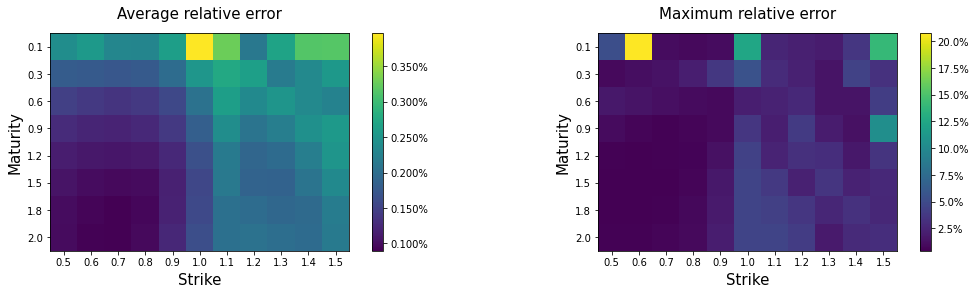

In [25]:
import matplotlib.ticker as mtick

prediction = [back_impVol(NNFun(x_test_transform[i])) for i in range(len(x_test_transform))]
plt.figure(1,figsize=(18,4))
ax = plt.subplot(1,2,1)
err = np.mean(100*np.abs((y_test-prediction)/y_test),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(N_maturities,N_strikes))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N_strikes-1,N_strikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,N_maturities-1,N_maturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax = plt.subplot(1,2,2)
err = 100*np.max(np.abs((y_test-prediction)/y_test),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(N_maturities,N_strikes))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,N_strikes-1,N_strikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,N_maturities-1,N_maturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.show()

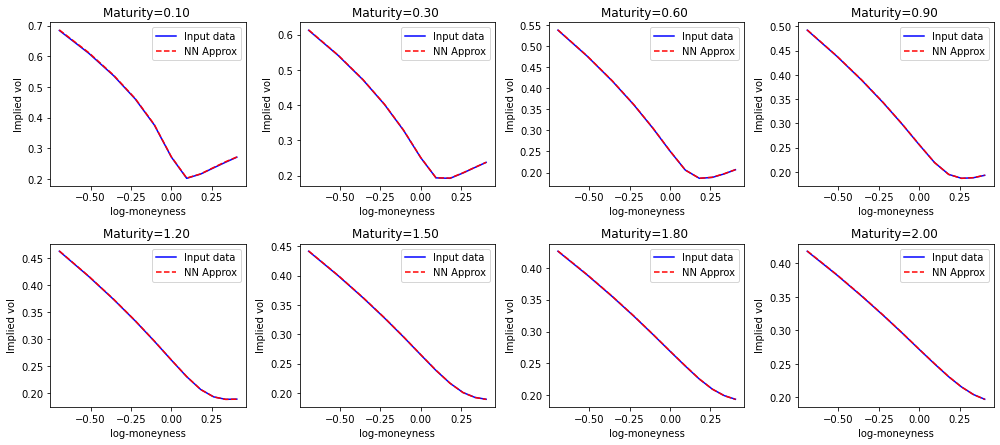

In [27]:
idx = random.randrange(len(dout))

ivol_sample = y_test[idx]
npar_sample = x_test_transform[idx]

ivol_NNfit = back_impVol(NNFun(npar_sample))
plt.figure(1, figsize=(14,12))
for i in range(N_maturities):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.log(strikes/spot), ivol_sample[i*N_strikes:(i+1)*N_strikes], 'b', label="Input data")
    plt.plot(np.log(strikes/spot), ivol_NNfit[i*N_strikes:(i+1)*N_strikes], '--r', label="NN Approx")
    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

In [28]:
def CostFunc(params, target):
    return np.sum(np.power((NNFun(params)-target), 2))
def Jacobian(params, target):
    return 2*np.sum((NNFun(params)-target)*NNGrad(params), axis=1)

In [29]:
true_params = x_test[idx]
ivol_target = y_test[idx]
ivol_target_transform = scale_impVol.transform(ivol_target.reshape(1, -1))

In [30]:
init = np.zeros(N_params)
bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]
res = scipy.optimize.minimize(lambda x: CostFunc(x, ivol_target_transform), x0=init, 
                              method='L-BFGS-B', jac= lambda x: Jacobian(x, ivol_target_transform), bounds=bounds, 
                              tol=1E-10, options={"maxiter":5000})
minimizer = res.x
optm_params = back_params(minimizer, lb, ub)

In [31]:
# compare calibrated parameters vs true
print('true params: '+ str(true_params))
print('optm params: '+ str(optm_params))

true params: [ 2.72596736  0.12953007  1.96409393  0.09519829 -0.7690032 ]
optm params: [ 2.71724449  0.12937234  1.95332558  0.09434548 -0.76890267]


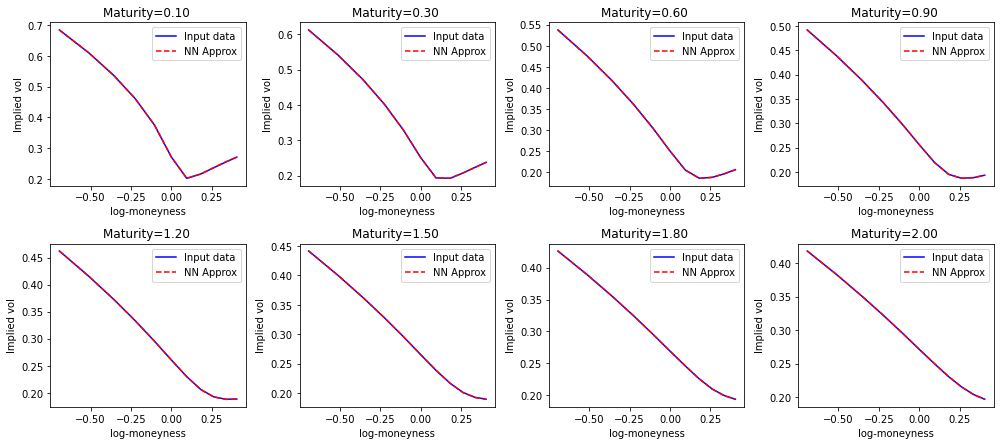

In [32]:
ivol_NNfit = back_impVol(NNFun(minimizer))
plt.figure(1, figsize=(14,12))
for i in range(N_maturities):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.log(strikes/spot), ivol_target[i*N_strikes:(i+1)*N_strikes], 'b', label="Input data")
    plt.plot(np.log(strikes/spot), ivol_NNfit[i*N_strikes:(i+1)*N_strikes], '--r', label="NN Approx")
    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()